# Tuning the kinetic parameters for asphaltene precipitation ($k_P$) and aggregation ($k_{Ag}$)

:star: **Objective**: optimize {$k_P, k_{Ag}$} parameters to fit the system of differential equations to experimental data.

differential equations:

$\frac{dC}{dt} = k_P(C_{f} - C_{eq})$

$\frac{dC_{Ag}}{dt} = K_{Ag}(C^2)$, where $K_{Ag} = k_{Ag}C_{a_0}$

initial conditions:

$C(t=0)=0$

$C_{f}(t=0)=1$

From the optimized set of {$k_P, k_{Ag}$}, the coefficients {$a_0, a_1, c_0$} are calculated. These coefficients depend on Temperature and viscosity.

$\ln{k_P} = \ln{a_0} - a_1/T$

$k_{Ag} = \frac{1}{750}\frac{2}{3}\frac{RT}{\mu}c_0$

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [3]:
# define utility functions
def unitConvert_T(val, unit_in: str, unit_out: str) -> float:
    '''unit converter for temperature'''
    if unit_in.upper() == 'F' and unit_out.upper() == 'K':
        return (val - 32) * 5/9 + 273.15
    elif unit_in.upper() == 'C' and unit_out.upper() == 'K':
        return val + 273.15
    elif unit_in.upper() == 'F' and unit_out.upper() == 'C':
        return (val - 32) * 5/9

:memo: CJS note: I recommend using a `data` folder to store raw data and accessing the folder using a relative file path. We use relative file paths because the location of the data file is different on our different computers, but if the project root folders are the same, then relative file paths will work on our different computers.

There is also a Python library called [`pathlib`][pathlib] that helps to construct cross-platform (Windows, Mac, Linux) file paths. We don't need this feature now as we all use Windows, but it is good to know of the existence of this package in case we ever need it. 

<!--refs-->
[pathlib]: https://www.freecodecamp.org/news/how-to-use-pathlib-module-in-python/

In [4]:
# read aggregation test info data
file_name = './data/Ag_kinetics.xlsx'
df = pd.read_excel(file_name, sheet_name='Info', header=7, usecols='b:q')
df = df[df['sheet'].notna()]
display(df)

,Set,sheet,T (F),P (bar),Base,Solvent,S Amt (vol%),Precip,P Amt (vol%),Ceq (wtf Asp L1/T),visco_L1 (cP),dens_L1 (g/cc),SP_L1 (MPa^0.5),dens_Asp (g/cc),SP_Asp (MPa^0.5),Ca0 (kg/m3)
0,1,Set1,104.0,1.0,STL,Tol,75.0,C6,55.0,0.858282,0.485850,0.748791,15.670999,NaN,22.889265,14.752502
1,2,Set2,104.0,1.0,STL,Tol,75.0,C7,60.0,0.833403,0.537347,0.762251,15.816842,NaN,22.889265,13.570000
2,3,Set3,104.0,1.0,STL,Tol,75.0,C8,60.0,0.848633,0.614240,0.777780,15.970580,NaN,22.889265,13.846450
3,4,Set4,176.0,1.0,STL,Tol,75.0,C6,62.0,0.837227,0.362247,0.732269,15.038418,NaN,22.349547,12.466965
4,5,Set5,176.0,1.0,STL,Tol,75.0,C7,62.0,0.853216,0.419526,0.749536,15.227162,NaN,22.349547,12.760944
5,6,Set6,176.0,1.0,STL,Tol,75.0,C8,62.0,0.858430,0.550031,0.780260,15.563012,NaN,22.349547,13.284011


:memo: CJS note: I prefer using these [`class objects`][pyTutorial_classes] so that I can store all related data in a single variable.

For example, all of this information (`Ceq, Ca0, rho, mu, etc.`) are properties (or attributes, in Python object terminology) of the fluid.

Now, if I needed to pass all `fluid` information to a function, I could do the syntax of `my_fun_object()`:

```Python
def my_fun(Ceq, Ca0, rho, mu)
    '''passing all attributes to the function individually'''
    pass

def my_fun_object(fluid):
    '''passing all attributes to the function packaged in the `fluid` variable'''
    pass
```

<!--refs-->
[pyTutorial_classes]: https://www.pythontutorial.net/python-oop/python-class-attributes/

In [5]:
# extract from dataframe
sht_data = df['sheet']

# construct `datasets` object
class datasets:
    pass

datasets.T = unitConvert_T(df['T (F)'].to_numpy(), 'F', 'K')
datasets.Ceq = df['Ceq (wtf Asp L1/T)'].to_numpy()
datasets.Ca0 = df['Ca0 (kg/m3)'].to_numpy()
datasets.mu = df['visco_L1 (cP)'].to_numpy()
datasets.rho = df['dens_L1 (g/cc)'].to_numpy()
datasets.rho_Asp = df['dens_Asp (g/cc)'].to_numpy()
datasets.SP = df['SP_L1 (MPa^0.5)'].to_numpy()
datasets.SP_Asp = df['SP_Asp (MPa^0.5)'].to_numpy()

print(f'T = {datasets.T}')
print(f'Ceq = {datasets.Ceq}')
print(f'SP_Asp = {datasets.SP_Asp}')

T = [313.15 313.15 313.15 353.15 353.15 353.15]
Ceq = [0.85828151 0.83340339 0.84863285 0.83722655 0.85321571 0.85843033]
SP_Asp = [22.88926524 22.88926524 22.88926524 22.34954706 22.34954706 22.34954706]


:memo: CJS note: by convention, `df` often denotes a Pandas Dataframe variable. 

If you do a `.to_list()` or .`to_numpy()` conversion, then avoid using names like `df` for the return as these functions return a `list` and `ndarray`, respectively.

```Python
df = df.to_numpy()  # NOT recommended (because `df` will no longer be a Dataframe after conversion)
xy = df.to_numpy()  # recommended
```

In [6]:
t_exp = []
c_exp = []

# loop over the sheet names and store time and exp data
# into t_exp and c_exp
for sht in sht_data:
    # read the relevant columns from the sheet into a DataFrame
    df_AgData = pd.read_excel(file_name, sheet_name=sht, usecols='b:c')
    data = df_AgData.to_numpy() 
    
    #these variables contain many arrays with time and experimental data
    #each dataset can be accessed with t_exp[index]
    t_exp.append(data[:,0])
    c_exp.append(data[:,1])

In [7]:
# define functions
def fun_C_dt(t, y, kP, kAg):
    '''
    arguments
    ---------
    t : float
        time [min]
    y : tuple(array[float])
        Cf : array[float]
        Cag : array[float]
        C : array[float]
    kP : float
        precipitation kinetics [1/s]
    kAg : float
        aggregation kinetics [1/s]
    
    return
    ------
    Cf_dt: array[float]
            dissolved asph concentration (Cf) wrt time
    Cag_dt: array[float]
            aggregated asph concentration (Cag) wrt time
    C_dt: array[float]
            primary particles concentration (C) wrt time  
    '''
    Cf, Cag, C = y
    
    Cf_dt = -kP*(Cf - Ceq)
    Cag_dt = kAg*C**2
    C_dt = kP*(Cf - Ceq) - kAg*C**2
    
    return [Cf_dt, Cag_dt, C_dt]

# initial conditions
y0 = [1.0, 0.0, 0.0]

# Define a function that returns the model values for given parameters
def Ag_model(t, kp, kag):
    sol = solve_ivp(fun=lambda t, y: fun_C_dt(t, y, kp, kag), t_span=t_span, y0=y0, t_eval=t)
    return sol.y[0]

Use curve_fit to find the best coefficient values to fit experimental data

In [8]:
# define initial guesses
p0 = np.array([.001, .001])

# initialize optimal coefficients list
kag_best = []
kp_best = []

# loop thru each set and extract exp data
for i, t_ in enumerate(t_exp):
    c_ = c_exp[i]
    Ceq = datasets.Ceq[i]
    
    # time span
    t_span = (0.0, t_exp[i][-1])
    
    # find optimal values for kp and kag
    popt, pcov = curve_fit(Ag_model, t_, c_, p0=p0, method='trf')
    kag_best.append(popt[0])
    kp_best.append(popt[1])

# Print the best values
print(f"Best kp: {kp_best}")
print(f"Best kag: {kag_best}")

Best kp: [0.0685089763327784, 0.07833158422146799, 0.9489825308687698, 0.06411125478835496, 0.05511364198445039, 0.02624017398957867]
Best kag: [1.5023463741710446, 1.8666122658065167, 11.31032824153077, 2.2225162295462457, 1.233378734172117, 0.8060831177602883]


R2 Score: 86.58991252398111 %


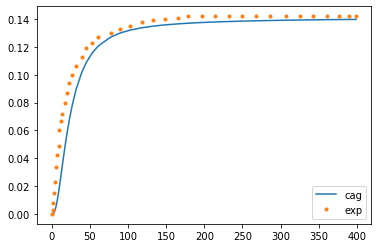

R2 Score: 49.81285981360821 %


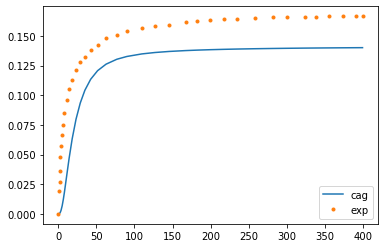

R2 Score: 27.286920678861893 %


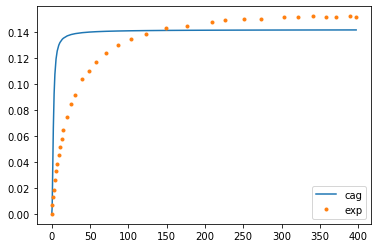

R2 Score: 79.38256991652557 %


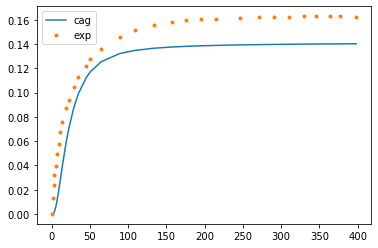

R2 Score: 95.001174984558 %


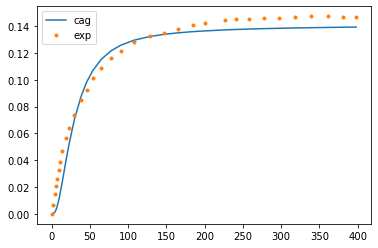

R2 Score: 93.26140266235241 %


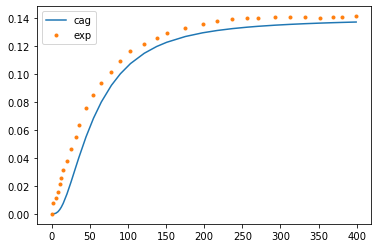

In [9]:
#Plot each function with their corresponding best coefficients
for i, t_ in enumerate(t_exp):
    
    #each set of time and data has different length and time span has to change accordingly
    t_span = (0.0, t_exp[i][-1])
    sol_best = solve_ivp(fun=lambda t, y: fun_C_dt(t, y, kp_best[i], kag_best[i]), t_span=t_span, y0=y0, t_eval=t_exp[i])
    
    #print R2 score to evaluate quality of approximation
    print('R2 Score:',r2_score(c_exp[i],sol_best.y[1])*100,'%')
    plt.plot(sol_best.t, sol_best.y[1], label='cag')
    plt.plot(t_exp[i], c_exp[i], label = 'exp', marker ='.', linestyle='None')
    plt.legend()
    plt.show()

Calculating a0, a1 and c0, from the obtained best kp and kag. The coefficients depend on T and mu.

In [115]:
# Define the functions for kp and kag
def kp(fluid_prop, a0, a1):
     T, Ceq, Ca0, mu, rho = fluid_prop
     return a0 / np.exp(a1 / T)

def kag(fluid_prop, c0, c1, c2):
    R = 8.314 # J/mol.K, gas constant
    T, Ceq, Ca0, mu, rho = fluid_prop
    return Ca0 * ((R * T) / (mu*1000)) * np.tanh(c0)
# Define the function to fit
#Temperature and viscosity now influence the model fitting
def fit_func(fluid_prop, a0, a1, c0, c1, c2):
    return np.hstack((kp(fluid_prop, a0, a1), kag(fluid_prop, c0, c1, c2))).astype(float)

fluid = (datasets.T, datasets.Ceq, datasets.Ca0, datasets.mu, datasets.rho)

# Perform the fit
p0 = np.array([1, .5, .5]) # initial guesses for a0, a1, and c0
popt, pcov = curve_fit(fit_func, fluid, np.concatenate((kp_best, kag_best)))

# Extract parameters
a0, a1, c0, c1, c2 = popt

# Print the results
print(f"a0 = {a0:.10f}")
print(f"a1 = {a1:.4f}")
print(f"c0 = {c0:.4f}")
print(f"c1 = {c1:.4f}")
print(f"c2 = {c2:.4f}")

a0 = 0.0000000066
a1 = -5582.8743
c0 = 0.0349
c1 = 1.0000
c2 = 1.0000


c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Using these coefficients solve the differential equations to obtain a new approximation

In [116]:
# define the differential equation system with all three coefficients and viscosity and temperature data
def derivatives_a0a1c0(t, y, a0, a1, c0, fluid_prop):
    R = 8.314
    T, Ceq, Ca0, mu = fluid_prop
    
    cf, cag, c = y
    
    Cf_dt = -(a0/np.exp(a1/T))*(cf - Ceq)
    Cag_dt = (Ca0*((1/750*1/3))*((R*T)/mu)*c0)*c**2
    C_dt = (a0/np.exp(a1/T))*(cf - Ceq) - (Ca0*((1/750*1/3))*((R*T)/mu)*c0)*c**2
    
    return [Cf_dt, Cag_dt, C_dt]

# time span, calculate for each data set
t_span = (0.0, t_exp[-1])

# initial conditions
y0 = [1.0, 0.0, 0.0]

# Define a function that returns the model values for given parameters
def model(t, a0, a1, c0):
    sol = solve_ivp(fun=lambda t, y: derivatives_a0a1c0(t, y, a0, a1, c0, fluid_prop), t_span=t_span, y0=y0, t_eval=t_exp)
    return sol.y[0]

Plot the new function given by coefficients a0, a1 and c0

R2 Score: 97.78805009076908 %


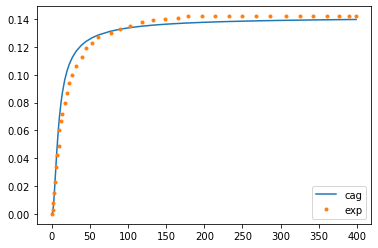

R2 Score: 93.6321098018248 %


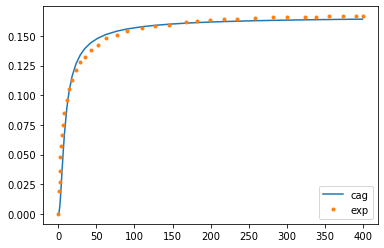

R2 Score: 93.45477597761817 %


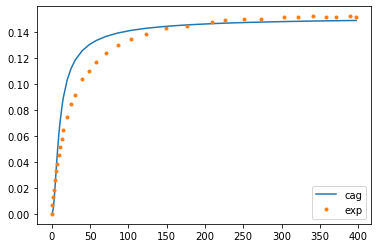

R2 Score: 83.14034658615503 %


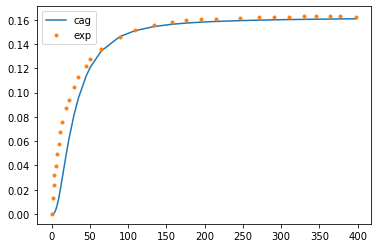

R2 Score: 95.2974637402283 %


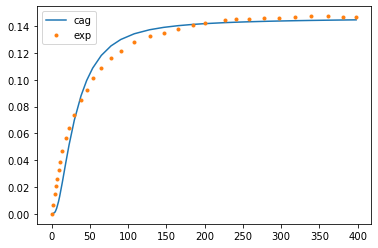

R2 Score: 97.3084964105626 %


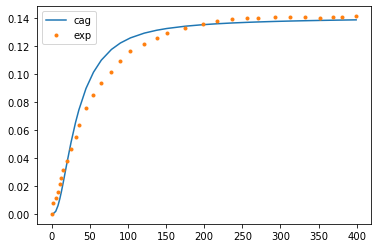

In [117]:
for i, t_ in enumerate(t_exp):

    fluid = (datasets.T[i], datasets.Ceq[i], datasets.Ca0[i], datasets.mu[i])

    t_span = (0.0, t_exp[i][-1])
    sol_best = solve_ivp(fun=lambda t, y: derivatives_a0a1c0(t, y, a0, a1, c0, fluid), t_span=t_span, y0=y0, t_eval=t_exp[i])
    
    print('R2 Score:',r2_score(c_exp[i],sol_best.y[1])*100,'%')
    plt.plot(sol_best.t, sol_best.y[1], label='cag')
    plt.plot(t_exp[i], c_exp[i], label = 'exp', marker ='.', linestyle='None')
    plt.legend()
    plt.show()

Calculating a0, a1 and c0 directly

In [118]:
# Define a function that returns the model values for given parameters
def model_a0a1c0(t, a0, a1, c0):
    sol = solve_ivp(fun=lambda t, y: derivatives_a0a1c0(t, y, a0, a1, c0, mu, Ceq, T, ca0), t_span=t_span, y0=y0, t_eval=t)
    return sol.y[0]

#define initial guesses
p0 = [[.02, .02, .02],[.02, .02, .02],
      [.018, .018, .018],[.015, .015, .015],
      [.01, .01, .01],[.006, .006, .006]]

#initialize best coeffiecient vector
a0, a1, c0 = [], [], []

#this for loop takes experimental data from each set including its respective Ceq and time span.
#Coefficients are calculated using curve_fit
for i,t in enumerate(t_exp):
    c = c_exp[i]
    Ceq = Ceq_set[i]
    ca0 = ca0_set[i]
    mu = mu_set[i] * 1000
    
    # time span
    t_span = (0.0, t_exp[i][-1])
    # Use curve_fit to find the best values for kp and kag
    popt, pcov = curve_fit(model_a0a1c0, t, c, p0=p0[i], method='trf')
    a0.append(popt[0])
    a1.append(popt[1])
    c0.append(popt[2])

# Print the best values
print(f"Best a0: {a0}")
print(f"Best a1: {a1}")
print(f"Best c0: {c0}")

NameError: name 'Ceq_set' is not defined

In [ ]:
#solve and plot with best coefficients
for i in range(len(t_exp)):
    mu = mu_set[i]
    Ceq = Ceq_set[i]
    T = T_set[i]
    ca0 = ca0_set[i]

    t_span = (0.0, t_exp[i][-1])
    sol_best = solve_ivp(fun=lambda t, y: derivatives_a0a1c0(t, y, a0[i], a1[i], c0[i], mu, Ceq, T, ca0), t_span=t_span, y0=y0, t_eval=t_exp[i])
    
    print('R2 Score:',r2_score(c_exp[i],sol_best.y[1])*100,'%')
    plt.plot(sol_best.t, sol_best.y[1], label='cag')
    plt.plot(t_exp[i], c_exp[i], label = 'exp', marker ='.', linestyle='None')
    plt.legend()
    plt.show()